
💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY (LOGARITHMIC STEPS)
 Step  Price (₹)  Investment (₹)  Quantity  Actual Invested (₹)  Cumulative Qty  Average Cost (₹)
    1     100.00         1024.26        10              1000.00              10           100.000
    2      92.59         1504.60        16              1481.40              26            95.438
    3      85.72         2210.21        25              2143.11              51            90.677
    4      79.37         3246.72        40              3174.80              91            85.707
    5      73.49         4769.31        64              4703.15             155            80.661
    6      68.04         7005.95       102              6940.03             257            75.652
    7      63.00        10291.49       163             10268.36             420            70.740
    8      58.33        15117.83       259             15106.55             679            66.005
    9      54.00        22207.55       411             

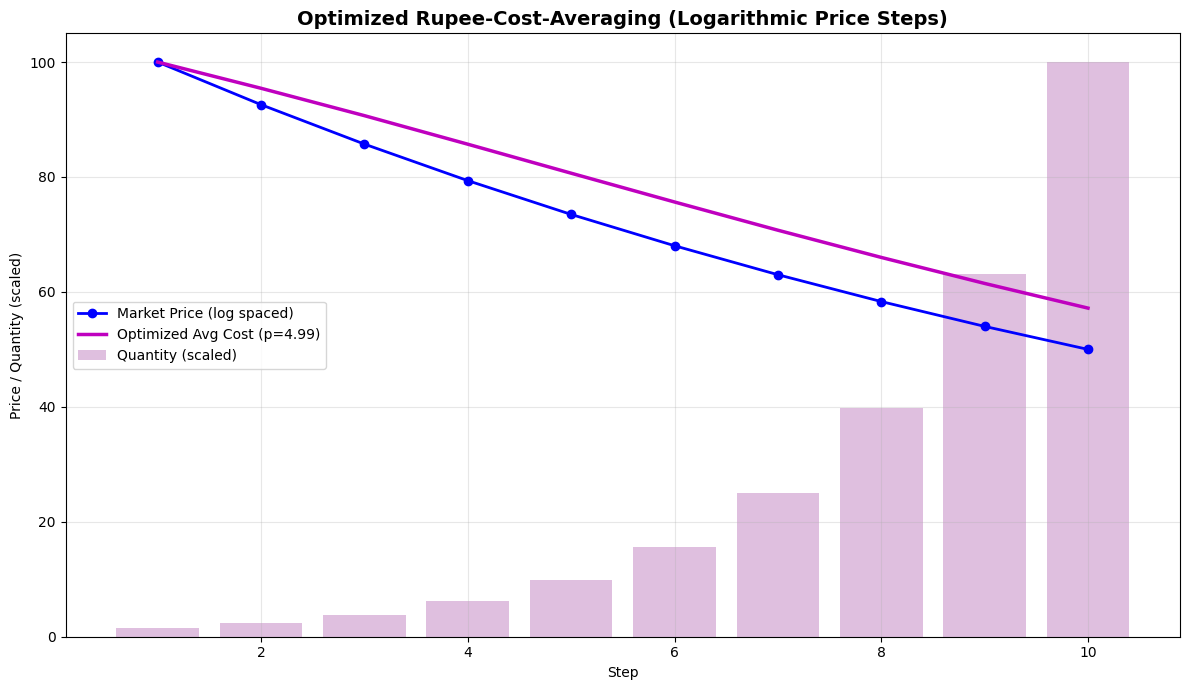


INSIGHTS:
--------------------------------------------------------------------------------
✓ Optimal sensitivity factor p = 4.99
→ Strategy invests *more aggressively* during price dips (steeper allocation).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar


# =====================================================
# 1️⃣ COMPUTATION MODULE
# =====================================================
def simulate_dca(prices, total_investment, p):
    """
    Simulate Rupee-Cost-Averaging with weighting proportional to (1/price)^p.
    Returns DataFrame, cumulative stats, and average cost.
    """
    weights = (1 / prices) ** p
    weights /= np.sum(weights)

    investments = total_investment * weights
    quantities = np.floor(investments / prices).astype(int)
    actual_investments = quantities * prices

    cumulative_qty = np.cumsum(quantities)
    cumulative_investment = np.cumsum(actual_investments)
    avg_cost = cumulative_investment / np.maximum(cumulative_qty, 1)

    df = pd.DataFrame(
        {
            "Step": np.arange(1, len(prices) + 1),
            "Price (₹)": np.round(prices, 2),
            "Investment (₹)": np.round(investments, 2),
            "Quantity": quantities,
            "Actual Invested (₹)": np.round(actual_investments, 2),
            "Cumulative Qty": cumulative_qty,
            "Average Cost (₹)": np.round(avg_cost, 3),
        }
    )

    total_qty = cumulative_qty[-1]
    total_spent = cumulative_investment[-1]

    return df, total_qty, total_spent, avg_cost[-1]


# =====================================================
# 2️⃣ OPTIMIZATION MODULE
# =====================================================
def find_optimal_p(prices, total_investment, bounds=(0, 5)):
    """Find the exponent p minimizing average acquisition cost."""

    def avg_cost_for_p(p):
        _, total_qty, total_spent, avg_cost = simulate_dca(prices, total_investment, p)
        return avg_cost if total_qty > 0 else np.inf

    result = minimize_scalar(avg_cost_for_p, bounds=bounds, method="bounded")
    return result.x, result.fun


# =====================================================
# 3️⃣ PLOTTING + REPORTING MODULE
# =====================================================
def plot_and_report(
    df,
    prices,
    total_qty,
    total_spent,
    final_price,
    opt_p,
    min_avg_cost,
    target_sell_price,
):
    """Visualize and print insights for the optimized DCA strategy."""
    cumulative_qty = df["Cumulative Qty"].values
    avg_cost = df["Average Cost (₹)"].values
    steps = df["Step"].values

    # Final statistics
    final_value = total_qty * final_price
    profit_loss = final_value - total_spent
    profit_loss_pct = (profit_loss / total_spent) * 100

    print("\n💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY (LOGARITHMIC STEPS)")
    print("=" * 90)
    print(df.to_string(index=False))
    print("=" * 90)
    print(f"Optimal weighting exponent (p): {opt_p:.3f}")
    print(f"Minimum achievable average cost: ₹{min_avg_cost:.3f}")
    print(f"Total Quantity Acquired: {total_qty}")
    print(f"Total Invested: ₹{total_spent:,.2f}")
    print(f"Final Price: ₹{final_price:.2f}")
    print(f"Final Portfolio Value: ₹{final_value:,.2f}")
    print(f"Profit/Loss: ₹{profit_loss:,.2f} ({profit_loss_pct:+.2f}%)")
    print("=" * 90)

    # Target simulation
    target_portfolio_value = total_qty * target_sell_price
    target_profit_loss = target_portfolio_value - total_spent
    target_profit_loss_pct = (target_profit_loss / total_spent) * 100

    print("\n🎯 TARGET SELL SIMULATION")
    print("=" * 90)
    print(f"Target Sell Price: ₹{target_sell_price:.2f}")
    print(f"Portfolio Value at Target: ₹{target_portfolio_value:,.2f}")
    print(
        f"Expected Profit/Loss: ₹{target_profit_loss:,.2f} ({target_profit_loss_pct:+.2f}%)"
    )
    print("=" * 90)

    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(steps, prices, "bo-", linewidth=2, label="Market Price (log spaced)")
    plt.plot(
        steps,
        avg_cost,
        "m-",
        linewidth=2.5,
        label=f"Optimized Avg Cost (p={opt_p:.2f})",
    )

    plt.bar(
        steps,
        df["Quantity"] * (max(prices) / max(df["Quantity"])),
        color="purple",
        alpha=0.25,
        label="Quantity (scaled)",
    )

    plt.title(
        "Optimized Rupee-Cost-Averaging (Logarithmic Price Steps)",
        fontsize=14,
        weight="bold",
    )
    plt.xlabel("Step")
    plt.ylabel("Price / Quantity (scaled)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Insights
    print("\nINSIGHTS:")
    print("-" * 80)
    print(f"✓ Optimal sensitivity factor p = {opt_p:.2f}")
    if opt_p > 1:
        print(
            "→ Strategy invests *more aggressively* during price dips (steeper allocation)."
        )
    elif opt_p < 1:
        print(
            "→ Strategy invests *more evenly* across steps (less responsive to dips)."
        )
    else:
        print("→ Strategy roughly matches standard inverse-price DCA weighting.")


# =====================================================
# 4️⃣ MAIN CLI INTERFACE
# =====================================================
def main():
    total_investment = 100000  # INR
    num_steps = 10
    initial_price = 100
    final_price = 50
    target_sell_price = 120

    # Logarithmic spacing of prices (equal percentage drop)
    prices = np.geomspace(initial_price, final_price, num_steps)

    # Find optimal exponent p
    opt_p, min_avg_cost = find_optimal_p(prices, total_investment)

    # Simulate DCA with optimal p
    df, total_qty, total_spent, _ = simulate_dca(prices, total_investment, opt_p)

    # Plot and report
    plot_and_report(
        df,
        prices,
        total_qty,
        total_spent,
        final_price,
        opt_p,
        min_avg_cost,
        target_sell_price,
    )


# =====================================================
# ENTRY POINT
# =====================================================
if __name__ == "__main__":
    main()